In [3]:
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np


from argparse import ArgumentParser
from deepscm.util import load_model
import torch
import os

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from argparse import Namespace
import torchvision.utils


from assets.pretrained_mnist import mnist

In [4]:
# auto reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
args = Namespace()
args.ckpt_path = "plots/digit/version_3/checkpoints/epoch=2926-step=617597.ckpt"
args.model_name = 'digit'

# Pull the model name and class
LitModelClass = load_model(args)

/work3/s164180/miniconda3/envs/thesis/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
# trainer args
train_parser = ArgumentParser()
train_parser = Trainer.add_argparse_args(train_parser)
train_args, _ = train_parser.parse_known_args()
logger = TensorBoardLogger("plots/tb")

train_args.logger = logger
trainer = Trainer.from_argparse_args(train_args, accelerator="gpu", devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
model_parser = ArgumentParser()
model_parser = LitModelClass.add_model_specific_args(model_parser)
model_args, _ = model_parser.parse_known_args(args=['--test_batch_size','4192'])
LitModel = LitModelClass.load_from_checkpoint(**vars(model_args), checkpoint_path=args.ckpt_path)

In [8]:
trainer.test(LitModel)

using device: cuda:0
set thickness_flow_lognorm.loc to 0.8860467076301575


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

[{}]

In [9]:
outputs = LitModel.outputs

In [10]:
vars(outputs).keys()

dict_keys(['do_label', 'do_thickness', 'do_intensity', 'label', 'x', 'thickness', 'intensity'])

In [11]:
x,label,do_label = outputs.x, outputs.label, outputs.do_label

In [12]:
do_label.shape

torch.Size([10000, 11, 1, 28, 28])

In [13]:
unique, idx, counts = torch.unique(label, sorted=True, return_inverse=True, return_counts=True)
_, ind_sorted = torch.sort(idx)
cum_sum = counts.cumsum(0)
cum_sum = torch.cat((cum_sum.new([0]),cum_sum[:-1]))
obs_batch_indicies = ind_sorted[cum_sum]


In [14]:
images = do_label[obs_batch_indicies, :, :,:,:]
images.shape

torch.Size([10, 11, 1, 28, 28])

In [15]:
# obtain proper order
im_ = []
for j in range(11):
    for i in range(10):
        im_.append(images[i,j,:,:,:])


grid = torchvision.utils.make_grid(im_, normalize=True, nrow=10)


import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
    fig.savefig('plots/figures/digit_counterfactuals.pdf')

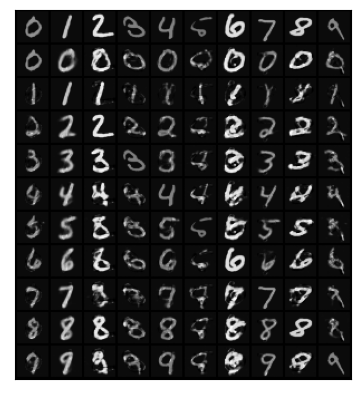

In [16]:
show(grid)

In [17]:
classifier = mnist(pretrained=True).cuda()

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


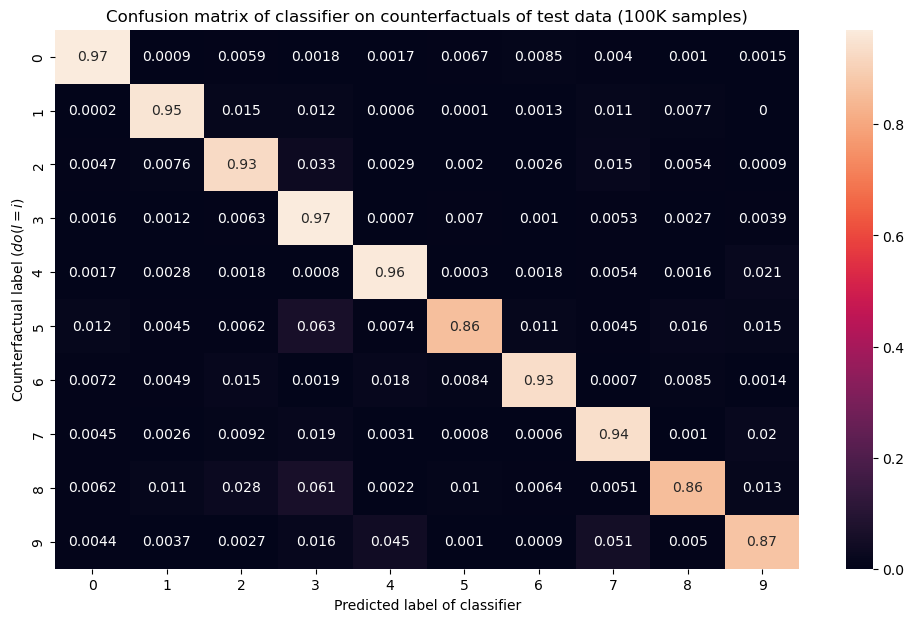

In [53]:
### Make confusion matrix of counterfactuals

y_pred = []
y_true = []

for i in range(10):
    counter_label = do_label[:,1+i,:,:,:]
    pred = classifier(counter_label.clone()).argmax(axis=1).data.cpu().numpy()
    y_pred.extend(pred)

    true = pred*0 + i
    y_true.extend(true)



###### Make confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

classes = ('0','1','2','3','4','5','6','7','8','9')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix,axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.title('Confusion matrix of classifier on counterfactuals of test data (100K samples)')
plt.xlabel('Predicted label of classifier')
plt.ylabel('Counterfactual label ($do(l=i)$')
plt.savefig('plots/figures/confusion_matrix_counterfactual.pdf')
plt.show()


counter_matrix = cf_matrix.copy()

In [19]:
# Confusion matrix of classifier

x = outputs.x
label = outputs.label

y_pred = []
y_true = []

y_true.extend(label.data.cpu().numpy())
y_pred.extend(classifier(x.clone()).argmax(axis=1).data.cpu().numpy())

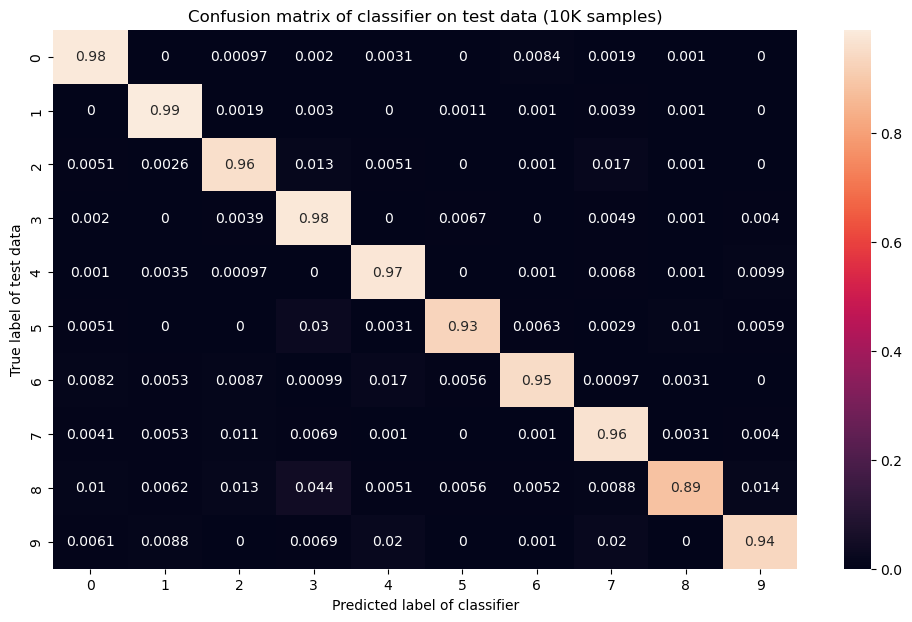

In [52]:
classes = ('0','1','2','3','4','5','6','7','8','9')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix,axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.title('Confusion matrix of classifier on test data (10K samples)')
plt.xlabel('Predicted label of classifier')
plt.ylabel('True label of test data')
plt.savefig('plots/figures/confusion_matrix_test.pdf')
plt.show()

test_matrix = cf_matrix.copy()

In [24]:
do_label.shape

torch.Size([10000, 11, 1, 28, 28])

In [28]:
outputs.label

tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0', dtype=torch.uint8)

In [44]:
do_label.shape

torch.Size([10000, 11, 1, 28, 28])

In [37]:
do_label[1,2,:,:,:].reshape((1,1,28,28)).shape

torch.Size([1, 1, 28, 28])

In [50]:
true = []
pred = []
from tqdm import tqdm

for i in tqdm(range(10000)):
    for j in range(10):
        if j == outputs.label[i].item():
            continue
        else:
            true.append(j)
            counter_label = do_label[i,1+j,:,:,:].reshape((1,1,28,28))
            pred_ = classifier(counter_label.clone()).argmax(axis=1).item()
            pred.append(pred_)
            


100%|████████████████████████████████████| 10000/10000 [00:21<00:00, 463.47it/s]


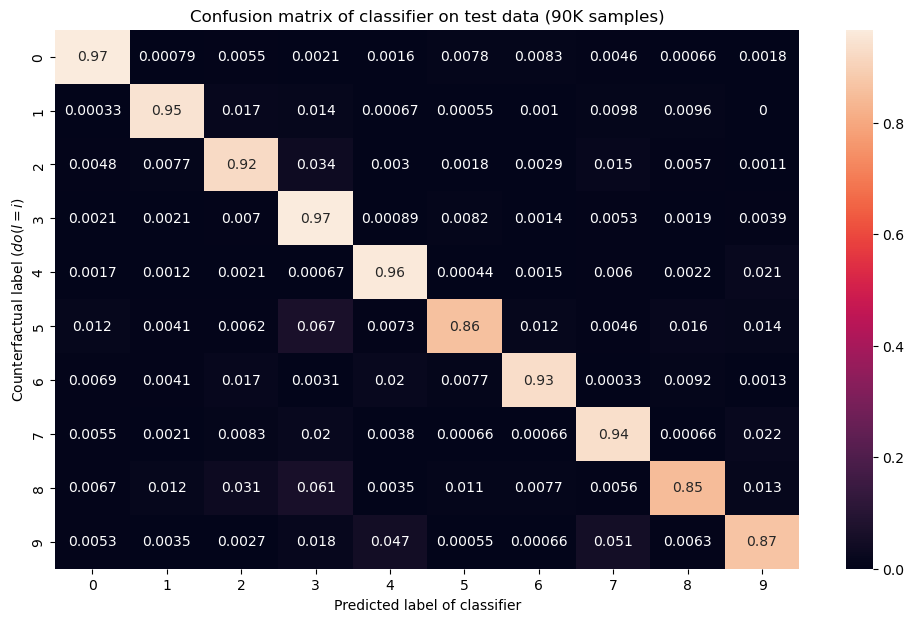

In [51]:
classes = ('0','1','2','3','4','5','6','7','8','9')

# Build confusion matrix
cf_matrix = confusion_matrix(true, pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix,axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.title('Confusion matrix of classifier on test data (90K samples)')
plt.xlabel('Predicted label of classifier')
plt.ylabel('Counterfactual label ($do(l=i)$')
plt.savefig('plots/figures/confusion_matrix_cor.pdf')
plt.show()

test_matrix = cf_matrix.copy()